# Data Preprocessing

In [1]:
import pandas as pd

### FUNCTIONS ###
def probetype_to_dataframe(input):
    # make dataframe from csv-file
    df = pd.read_csv(input, sep=',')

    # set probes as index
    df_i = df.set_index('probe')
    return df_i

def add_probetypes(df_dest, df_target):

    # search for fitting probe-ids
    df_merged = pd.merge(df_dest, df_target, on="probe")

    return df_merged

In [2]:
### MAIN ###

# rebuild illumina probe tables to dataframe with just probes and types
# returns dataframe
df_450 = probetype_to_dataframe('illumina-table-450.csv')
# df_850 = probetype_to_dataframe('illumina-table-450.csv') -> no 850 found

# convert methylation-tables to dataframes
#df_values_meth = pd.read_csv('methylation-rb/methylation_meth.wide.tsv', sep='\t')
df_values_meth = pd.read_csv('methylation-rb/short.tsv', sep='\t')

df_values_unmeth = pd.read_csv('methylation-rb/methylation_unmeth.wide.tsv', sep='\t')

# set index to probe-id
df_values_meth = df_values_meth.set_index('probe')
df_values_unmeth = df_values_unmeth.set_index('probe')

# match probes to type in methylation file
# returns new dataframe including probe types
df_meth_w_types = add_probetypes(df_450, df_values_meth)
df_unmeth_w_types = add_probetypes(df_450, df_values_unmeth)

print(df_meth_w_types.dtypes)
print(df_unmeth_w_types.dtypes)

type        object
RB_E_001     int64
RB_E_002     int64
RB_E_003     int64
RB_E_004     int64
             ...  
RB_E_077     int64
RB_E_078     int64
RB_E_079     int64
RB_E_080     int64
RB_E_081     int64
Length: 66, dtype: object
type        object
RB_E_001     int64
RB_E_002     int64
RB_E_003     int64
RB_E_004     int64
             ...  
RB_E_077     int64
RB_E_078     int64
RB_E_079     int64
RB_E_080     int64
RB_E_081     int64
Length: 66, dtype: object


# Normalization Methods

* Quantile Normalization (QN)
* Beta-Mixture Quantile Normalization (QN.BMIQ)
* Functional Normalization

## Quantile Normalization (by hand)
1. sort each column (each sample)
2. compute row means
3. replace original data in each column (forces all samples to have the same distribution)
4. Use average values to each sample in the original order

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# columns: samples
# rows: probes (Sonden)
data = np.random.randint(low=0, high=10, size=(5,4))
data_df = pd.DataFrame(data, index=['cg0', 'cg1', 'cg2', 'cg3', 'cg4'], columns=['sample 0','sample 1','sample 2','sample 3'])
data_df = df_meth_w_types
print(data_df)

           type  RB_E_001  RB_E_002  RB_E_003  RB_E_004  RB_E_005  RB_E_006  \
probe                                                                         
cg00035864   II       632       874       689       484       171       438   
cg00061679   II      1234      3163      1354      1783       139       884   
cg00063477   II      1827      3334      1353      1996       187      1815   
cg00005617   II     12919     12433     13714     12747      9402     14419   
cg00006815   II       683       935      1820       983      9077       796   
...         ...       ...       ...       ...       ...       ...       ...   
cg00107488   II      4416      1487      4243      3667      1473      4573   
cg00107490   II     14283     17241     16416     15753     16900     14969   
cg00107982    I      1710      3103      3963      3231      4981      1531   
cg00108569    I       311       321       464       388       467       692   
cg00110039   II      2038      1012      1522      1

In [4]:
# 1. Sorting
data_sorted = pd.DataFrame(np.sort(data_df.values, axis=0), index=data_df.index, columns=data_df.columns)
print(data_sorted)

           type RB_E_001 RB_E_002 RB_E_003 RB_E_004 RB_E_005 RB_E_006  \
probe                                                                   
cg00035864    I       81       75       58       18       47       65   
cg00061679    I      108       76       87      130      109       95   
cg00063477    I      119      106      149      133      131      134   
cg00005617    I      156      120      171      133      139      138   
cg00006815    I      160      126      176      134      157      146   
...         ...      ...      ...      ...      ...      ...      ...   
cg00107488   II    35764    35296    35461    31322    33153    32497   
cg00107490   II    38597    35558    35788    33159    33555    32806   
cg00107982   II    38659    35870    35997    34574    33625    32992   
cg00108569   II    41524    39377    41048    35816    34089    33978   
cg00110039   II    42186    42922    41993    36273    37174    35316   

           RB_E_007 RB_E_008 RB_E_009  ... RB_E_06

In [5]:
# 2. Means
data_mean = data_sorted.mean(axis=1)
print(data_mean)

probe
cg00035864   NaN
cg00061679   NaN
cg00063477   NaN
cg00005617   NaN
cg00006815   NaN
              ..
cg00107488   NaN
cg00107490   NaN
cg00107982   NaN
cg00108569   NaN
cg00110039   NaN
Length: 2398, dtype: float64


C:\Users\lisar\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [6]:
# 3. Replace
data_mean.index = np.arange(1, len(data_mean)+1)
print(data_mean)

1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
        ..
2394   NaN
2395   NaN
2396   NaN
2397   NaN
2398   NaN
Length: 2398, dtype: float64


In [7]:
# 4. Ranking
data_qn = data_df.rank(method="min").stack().astype(int).map(data_mean).unstack()

In [8]:
print(data_qn)

            type  RB_E_001  RB_E_002  RB_E_003  RB_E_004  RB_E_005  RB_E_006  \
probe                                                                          
cg00035864   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00061679   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00063477   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00005617   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00006815   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...          ...       ...       ...       ...       ...       ...       ...   
cg00107488   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00107490   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00107982   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00108569   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
cg00110039   NaN       NaN       NaN    

# Quantile normalization with qnorm

In [12]:
import pandas as pd
import qnorm

df_qn = qnorm.quantile_normalize(df_values_meth, axis=1)
df_values_meth = df_values_meth.head(50)
df_qn = df_qn.head(50)
df_log = df_values_meth(lambda x: math.log10(x))

print(df_log)
print(df_values_meth)
print(df_qn)

TypeError: 'DataFrame' object is not callable

### Raw plot

(0.0, 20000.0)

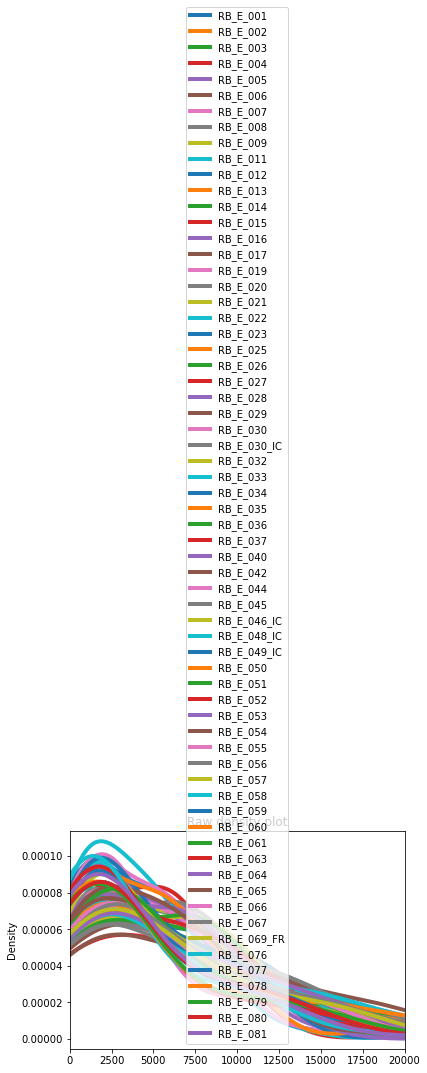

In [10]:
df_values_meth.plot.density(linewidth=4)
plt.title("Raw density plot")
plt.xlim(0,20000)

### Raw log plot

In [11]:
import math

df_values_meth_log = df_values_meth.applymap(log10, na_action='ignore')

df_values_meth_log.plot.density(linewidth=4)
plt.title("Raw density plot")
#plt.xlim(0,20000)

NameError: name 'log10' is not defined

### Quantile normalized plot

In [ ]:
df_qn.plot.density(linewidth=4)
plt.title("Quantile normalized densities")
plt.xlim(0,20000)

In [ ]:
### Raw boxplot

In [ ]:
sns.boxplot(data=data_df)
plt.xlabel("Samples")
plt.ylabel("Measurement")
plt.title("Raw Data Boxplot")

In [ ]:
### Quantile normalized boxplot

In [ ]:
sns.boxplot(data=data_qn)
plt.xlabel("Samples")
plt.ylabel("Measurement")
plt.title("Raw Data Boxplot")

https://ai.recodeminds.com/news/computing-quantile-normalization-in-python/

## Functional Normalization
* view methylated (M) and unmethylated (U) channels separately
* FN applied separately to type I and II probes
* 4 separate applications of FN using the exact same covariance matrix with more than 100,000 probes in each normalization fit
* normalize mapping of probes to sex chromosomes separately from autosomal probes (males and females separately)
* X-chromosome: functional normalization
* Y-chromosome: quantile normalization (small number of probes is not good for FN)

In [ ]:
# Y1 - Yn : high-dimensional vectors (observations)
list1 = np.random.randint(low=0, high=10, size=(10))
Y1 = np.array(list1)
print("Vector Y1:", Y1)


In [ ]:
# Z : matrix with scalar covariates (nxm)
# i indexing samplex, j indexing covariates
# covariates are associated with unwanted biological cariation
n = 10
m = 10
matrix = np.random.rand(n,m)
print(matrix)

In [ ]:
# for each Y we form the empirical quantile function for its marginal distribution q
# r = [0,1]
# a (alpha) = mean of the quantile functions across all samples
# b (beta) = coefficient functions which are assumed to be independent and centered around 0
